In [1]:
%load_ext autoreload 
%autoreload 2
import numpy as np
import random
from colossus.cosmology import cosmology
cosmology.setCosmology('planck18')
from colossus.halo import concentration, mass_defs
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib
from pylab import rcParams
from matplotlib import rc;rc('text', usetex=True);rc('font', weight='bold');matplotlib.rcParams['text.latex.preamble'] = r'\boldmath'
rcParams['font.family'] = 'serif'
rc('text.latex',preamble=r'\usepackage{/Volumes/Extreme_SSD/codes/master_thesis/code/configs/apjfonts}')
sz_ft = 18
sz_lb = 18
color_arr = ['firebrick', 'dodgerblue', 'forestgreen']
from tqdm import tqdm
import cosmo
import lensing_estimator
from cosmo import CosmoCalc
import lensing
import foregrounds as fg
import experiments as exp
import sims
import stats
import tools

In [2]:
nber_clus = 3000
nber_rand = 50000
nber_cov = 1000
nber_runs = 25
map_params = [180, 0.5, 180, 0.5]
l, cl = CosmoCalc().cmb_power_spectrum()
l, bl = exp.beam_power_spectrum(beam_fwhm = 1.0)
noiseval_arr = [0.1, 0.25, 0.5, 1, 2, 3, 5]
nl_arr = []
cl_noise_arr = []
for noiseval in noiseval_arr:
    l, nl = exp.white_noise_power_spectrum(noiseval_white = noiseval)
    l, nl_deconvolved =exp.white_noise_power_spectrum(noiseval_white = noiseval, beam_fwhm = 1.0)
    nl_arr.append(nl)
    cl_noise_arr.append(nl_deconvolved)
z = 0.7
cluster = [2e14, cosmo.concentration_parameter(2e14, 0.7, 0.674), 0.7]
mass_int = np.arange(0, 4, 0.1)

/Volumes/Extreme_SSD/codes/master_thesis/code/cosmo.py:98: RuntimeWarning: invalid value encountered in true_divide
  cl = dl * 2 * np.pi / (l*(l+1))


In [3]:
%%script false --no-raise-error
for i, noiseval in enumerate(noiseval_arr):
    maps_rand = sims.cmb_mock_data(map_params, l, cl,  bl = bl, nl = nl_arr[i], nber_obs = nber_rand)
    stack_bg = lensing_estimator.stack(map_params, maps_rand, l = l, cl = cl, cl_noise = cl_noise_arr[i])
    del maps_rand
    np.save('/Volumes/Extreme_SSD/codes/master_thesis/code/results/stack_bg_50000rand_'+str(noiseval)+'uK-arcmin.npy', stack_bg)

In [4]:
%%script false --no-raise-error
for i, noiseval in enumerate(noiseval_arr):
    covariance_matrix, _ = lensing_estimator.covariance_and_correlation_matrix(nber_cov, nber_clus, map_params, l, cl, bl = bl, nl = nl_arr[i], cl_noise = cl_noise_arr[i])
    np.save('/Volumes/Extreme_SSD/codes/master_thesis/code/results/covariance_matrix_3000clus_'+str(noiseval)+'uK-arcmin.npy', covariance_matrix)

In [5]:
%%script false --no-raise-error
noiseval_arr1 = [0.25, 0.5, 1, 3]
nl_arr1 = []
cl_noise_arr1 = []
for noiseval1 in noiseval_arr1:
    l, nl1 = exp.white_noise_power_spectrum(noiseval_white = noiseval1)
    l, nl_deconvolved1 =exp.white_noise_power_spectrum(noiseval_white = noiseval1, beam_fwhm = 1.0)
    nl_arr1.append(nl1)
    cl_noise_arr1.append(nl_deconvolved1)
for i, noiseval1 in enumerate(noiseval_arr1):
    covariance_matrix, _ = lensing_estimator.covariance_and_correlation_matrix(nber_cov, nber_clus, map_params, l, cl, bl = bl, nl = nl_arr1[i], cl_noise = cl_noise_arr1[i])
    np.save('/Volumes/Extreme_SSD/codes/master_thesis/code/results/covariance_matrix_3000clus_'+str(noiseval1)+'uK-arcmin.npy', covariance_matrix)

In [6]:
%%script false --no-raise-error
for i, noiseval in enumerate(noiseval_arr):
    model_profiles = lensing_estimator.model_profiles(nber_clus, map_params, l, cl, mass_int, z, bl = bl, cl_noise = cl_noise_arr[i])
    np.save('/Volumes/Extreme_SSD/codes/master_thesis/code/results/model_profiles_'+str(noiseval)+'uK-arcmin.npy', model_profiles) 

In [7]:
%%script false --no-raise-error

stacks_bg = []
covariance_matrices = []
model_profiles = []
for noiseval in noiseval_arr:
    stacks_bg.append(np.load('/Volumes/Extreme_SSD/codes/master_thesis/code/results/stack_bg_50000rand_'+str(noiseval)+'uK-arcmin.npy'))
    covariance_matrices.append(np.load('/Volumes/Extreme_SSD/codes/master_thesis/code/results/covariance_matrix_3000clus_'+str(noiseval)+'uK-arcmin.npy')) 
    model_profiles.append(np.load('/Volumes/Extreme_SSD/codes/master_thesis/code/results/model_profiles_'+str(noiseval)+'uK-arcmin.npy'))  



lk_arr = []
for i in tqdm(range(nber_runs)):
    maps_clus = sims.cmb_test_data(map_params, l, cl, cluster = cluster, bl = bl, nl = nl_arr, nber_obs = nber_clus, noise_comparison = True)
    
    stacks_clus = []
    for j in range(len(maps_clus)):
        stack_clus = lensing_estimator.stack(map_params, maps_clus[j], l = l, cl = cl, cl_noise = cl_noise_arr[j]) 
        stacks_clus.append(stack_clus)

    lensing_dipole_profiles = []
    for j in range(len(maps_clus)):
        bins, lensing_dipole_profile, _ = lensing_estimator.lensing_dipole(map_params, stacks_clus[j], stacks_bg[j])
        lensing_dipole_profiles.append(lensing_dipole_profile)

    datasets = []
    for j in range(len(maps_clus)):
        dataset = bins, lensing_dipole_profiles[j], covariance_matrices[j]
        datasets.append(dataset)

    for j range(len(maps_clus)):
        likelihood, _, _ = stats.run_ml(datasets[j], model_profiles[j], mass_int)
        lk_mass_int_values, lk_values = likelihood
        lk_arr.append(lk_values)

    del maps_clus

    
    
likelihoods_noise_sorted = []
for i in range(len(noiseval_arr)):
    likelihoods_for_noise_i = []
    for j in range(nber_runs):
        likelihood_for_noise_i.append(lk_arr[j][i])
    likelihoods_noise_sorted.append(likelihood_for_noise_i)
    
    
    
mass_arr = []
error_arr = []    
for i in range(len(noiseval_arr)):
    comb_lk, mass_comb_lk, error_comb_lk = stats.combined_likelihood(lk_mass_int_values, likelihoods_noise_sorted[i])
    mass_arr.append(mass_comb_lk)
    error_arr.append(error_comb_lk)

    
frac_mass_unc = [error_arr[i]/mass_arr[i] for i in range(len(noiseval_arr))]
np.save('/Volumes/Extreme_SSD/codes/master_thesis/code/results/mass_results_estimator_comparison.npy', frac_mass_unc)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


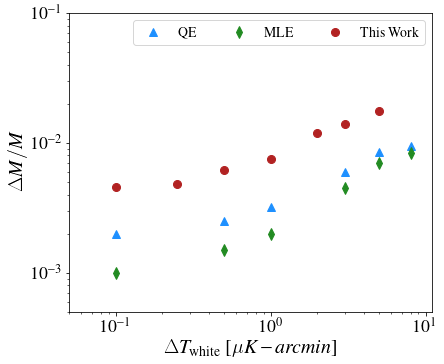

In [8]:
noiseval_arr = [0.1, 0.25, 0.5, 1, 2, 3, 5]
frac_mass_unc = np.load('/Volumes/Extreme_SSD/codes/master_thesis/code/results/mass_results_estimator_comparison.npy')
noiseval_arr1 = [0.1, 0.5, 1, 3, 5, 8]
qe = [0.002, 0.0025, 0.0032, 0.006, 0.0085, 0.0094]
mle = [0.001, 0.0015, 0.002, 0.0045, 0.007, 0.0084]
fig, ax = plt.subplots( figsize=(6.5,5.5))
ax.set_xscale('log')
ax.set_yscale('log')
scal_fac = np.sqrt(75000./100000.)
ax.plot(noiseval_arr1, np.asarray(qe),  color = color_arr[1], ls = '', marker = '^',markersize = sz_lb-10, label = 'QE')
ax.plot(noiseval_arr1, mle,  color = color_arr[2], ls = '', marker = 'd',markersize = sz_lb-10, label = 'MLE')
ax.plot(noiseval_arr, np.asarray(frac_mass_unc)*scal_fac,  color = color_arr[0], ls = '', marker = 'o',markersize = sz_lb-10, label = 'This Work')
ax.set_xlabel(r'$\Delta T_{\rm white}\ [\mu K-arcmin]$', fontsize = sz_ft+2)
ax.set_ylabel(r'$\Delta M/M$', fontsize = sz_ft+2)
ax.tick_params(labelsize = sz_lb)
ax.legend(ncol = 3, prop={'size': sz_lb-4}) 
ax.set_ylim(0.0005, 0.1)
ax.set_xlim(0.05, 11)
fig.savefig('/Volumes/Extreme_SSD/codes/master_thesis/code/figures/estimator_comparison.eps', dpi = 200., bbox_inches = 'tight', pad_inches = 0.1)